## Create library

In [1]:
from huggingface_hub import login
login('xxxx')


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/amirkazemim/.cache/huggingface/token
Login successful


In [2]:
from datasets import Dataset
from datasets import DatasetDict
import pandas as pd
import numpy as np
from datasets import load_dataset
from create_set import create_dataset, create_number_labs
import matplotlib.pyplot as plt


In [96]:
df_csv = pd.read_csv('../scrape/test_food_bev_alc.csv')
unq_id = df_csv.typeID.unique()
print([fnc(unq_id) for fnc in [len, max]])
df_csv['link'] = df_csv['link'].str.replace('rt.com//product','rt.com/product')
df_copy = df_csv.copy()
df_csv.drop(columns=['typeID', 'link'], inplace=True)
df_csv.rename(columns={"product": "text"}, inplace=True)
id_chk = create_number_labs(df_csv, 'label', 7, base_lab=False)
df_csv['label'] = df_csv['base_label'].copy()
df_csv = df_csv[['text', 'label']]
# df_csv['orig_lab'] = df_csv['label'].copy()
dset = create_dataset(df_csv)
prod = dset.get_train_val_test([.8,.1,.1])

df_csv.head()

[2244, 2327]


,text,label
2007,Great Lakes Brewing Co. Christmas Ale Glaze14 fl oz,1
2008,BarkLogic Beer Line Cleaner1 L,1
2009,Ferment'n Home Fermentation Kit1 ct,1
2010,Shipyard Brewing Company Seasonal Beer in Bottles12 fl oz,1
2011,Canlzo Eco-Friendly Fireeach,1


In [4]:
u, sel_ind, indices = np.unique(id_chk.label_array, return_index=True, return_inverse=True, axis = 0)
# srt_ind = np.lexsort((u[:,3], u[:,2], u[:,1], u[:,0]))
# u = u[srt_ind]
# indices = indices[srt_ind]
# labs_nums = np.arange(len(u))
# tst_lab = labs_nums[indices]

In [5]:
# np.max(indices), srt_ind.shape, u.shape, indices.shape, sel_ind.shape

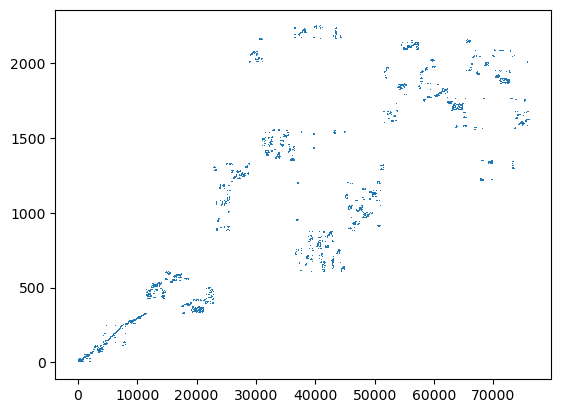

In [6]:
plt.plot(df_csv['label'], ',')

In [7]:
# df_csv['label'] = ((df_csv['label']-df_csv['label'].min())*100000/(df_csv['label'].max()-df_csv['label'].min())).astype(int)
imdb = dset.get_train_val_test([.8,.1,.1])


In [103]:
imdb['test']['text']

["Smithwick's Red Ale Beer12 fl oz",
 'Michelob Ultra Amber Light Beer12 fl oz',
 'Chandeleur Tangerine12 fl oz',
 'Firestone Under Currants American Wild Ale375 ml',
 'Wicked Weed Black Angel16.9 fl oz',
 'Allagash Beer, Honeyberry Tumble12.7 fl oz',
 'Sierra Nevada Terra Incognita beer750 ml',
 'Firestone Barley Wine Ale Sucaba Vintage 201912 fl oz',
 'Sierra Nevada Ale, Bigfoot, Barleywine Style, 201112 fl oz',
 'Deschutes 2014 Reserve Mirror Mirror22 fl oz',
 'Smuttynose Ale, Barleywine Style22 fl oz',
 'Morgan Territory Brewing Old Diablo Beer22 fl oz',
 'Shock Top Belgian White12 fl oz',
 'Leffe Original Belgian Abbey Ale11.2 fl oz',
 'Victory Sour Monkey Sour Tripel 12/12oz cans12 oz',
 'Victory Beer, Fruited Sour Tripel, Berry Monkey12 fl oz',
 'New Belgium Brewing Honey Orange Tripel12 fl oz',
 'Firestone 805 Blonde Ale12 fl oz',
 'Kona Big Wave Big Wave Golden Ale Beer25 fl oz',
 'Pizza Port Brewing Co. Beer, Blonde Ale, California Honey16 fl oz',
 'Big Sky Brewing Co. Beer, 

## Tokenizer

In [8]:
from transformers import AutoTokenizer

# checkpoint = "distilbert-base-cased"
checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

imdb_encoded = imdb.map(tokenize_function, batched=True, batch_size=None)
imdb_encoded

Map:   0%|          | 0/60754 [00:00<?, ? examples/s]

Map:   0%|          | 0/7594 [00:00<?, ? examples/s]

Map:   0%|          | 0/7595 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 60754
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7594
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7595
    })
})

## Tiny IMDB

In [9]:
import transformers
import re

[x for x in dir(transformers) if re.search(r'^AutoModel', x)]

['AutoModel',
 'AutoModelForAudioClassification',
 'AutoModelForAudioFrameClassification',
 'AutoModelForAudioXVector',
 'AutoModelForCTC',
 'AutoModelForCausalLM',
 'AutoModelForDepthEstimation',
 'AutoModelForDocumentQuestionAnswering',
 'AutoModelForImageClassification',
 'AutoModelForImageSegmentation',
 'AutoModelForImageToImage',
 'AutoModelForInstanceSegmentation',
 'AutoModelForKeypointDetection',
 'AutoModelForMaskGeneration',
 'AutoModelForMaskedImageModeling',
 'AutoModelForMaskedLM',
 'AutoModelForMultipleChoice',
 'AutoModelForNextSentencePrediction',
 'AutoModelForObjectDetection',
 'AutoModelForPreTraining',
 'AutoModelForQuestionAnswering',
 'AutoModelForSemanticSegmentation',
 'AutoModelForSeq2SeqLM',
 'AutoModelForSequenceClassification',
 'AutoModelForSpeechSeq2Seq',
 'AutoModelForTableQuestionAnswering',
 'AutoModelForTextEncoding',
 'AutoModelForTextToSpectrogram',
 'AutoModelForTextToWaveform',
 'AutoModelForTokenClassification',
 'AutoModelForUniversalSegmentatio

In [10]:
import torch
from transformers import BertForSequenceClassification

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")

num_labels = df_csv['label'].max() + 1
print(num_labels)
# num_labels = 100000
# model = (BertForSequenceClassification
#          .from_pretrained(checkpoint, num_labels=num_labels)
#          .to(device))

# for param in model.bert.parameters():
#     param.requires_grad = False

2244


In [11]:
model = (BertForSequenceClassification
         .from_pretrained('amirkazemim/bert-base-cased-finetuned-products', num_labels=num_labels)
         .to(device))

In [12]:
from datasets import DatasetDict

tiny_imdb = DatasetDict()
tiny_imdb['train'] = imdb['train'].shuffle(seed=1).select(range(50))
tiny_imdb['validation'] = imdb['validation'].shuffle(seed=1).select(range(10))
tiny_imdb['test'] = imdb['test'].shuffle(seed=1).select(range(10))

tiny_imdb_encoded = tiny_imdb.map(tokenize_function, batched=True, batch_size=None)
tiny_imdb_encoded

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10
    })
})

In [13]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(tiny_imdb_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-tiny-prod"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )
training_args

/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_steps=None,
eval_strategy=epoch,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsd

In [13]:
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tiny_imdb_encoded["train"],
                  eval_dataset=tiny_imdb_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

  0%|          | 0/14 [00:00<?, ?it/s]

{'loss': 7.7589, 'grad_norm': 9.368273735046387, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.86}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 7.779425144195557, 'eval_runtime': 0.1909, 'eval_samples_per_second': 52.389, 'eval_steps_per_second': 10.478, 'epoch': 1.0}
{'loss': 7.6091, 'grad_norm': 10.597159385681152, 'learning_rate': 2.8571428571428573e-06, 'epoch': 1.71}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 7.74707555770874, 'eval_runtime': 0.0587, 'eval_samples_per_second': 170.332, 'eval_steps_per_second': 34.066, 'epoch': 2.0}
{'train_runtime': 4.6232, 'train_samples_per_second': 21.63, 'train_steps_per_second': 3.028, 'train_loss': 7.65201963697161, 'epoch': 2.0}


In [14]:
preds = trainer.predict(tiny_imdb_encoded['test'])

preds.label_ids, preds.predictions.argmax(axis=-1)

  0%|          | 0/2 [00:00<?, ?it/s]

(array([1623, 1208, 1974,  391,  862,  404, 2231, 1259, 1306, 2125]),
 array([614, 333, 614, 614, 614, 614, 614, 614, 614, 614]))

In [14]:
from sklearn.metrics import accuracy_score

# accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))

In [15]:
def get_accuracy(preds):
  predictions = preds.predictions.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))
  return {'accuracy': accuracy}


In [17]:
trainer = Trainer(model=model,
                  compute_metrics=get_accuracy,
                  args=training_args,
                  train_dataset=tiny_imdb_encoded["train"],
                  eval_dataset=tiny_imdb_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

  0%|          | 0/14 [00:00<?, ?it/s]

{'loss': 7.4626, 'grad_norm': 8.726988792419434, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.86}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 7.881704807281494, 'eval_accuracy': 0.0, 'eval_runtime': 0.0589, 'eval_samples_per_second': 169.672, 'eval_steps_per_second': 33.934, 'epoch': 1.0}
{'loss': 7.4768, 'grad_norm': 9.22647476196289, 'learning_rate': 2.8571428571428573e-06, 'epoch': 1.71}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 7.8744659423828125, 'eval_accuracy': 0.0, 'eval_runtime': 0.0598, 'eval_samples_per_second': 167.118, 'eval_steps_per_second': 33.424, 'epoch': 2.0}
{'train_runtime': 3.1783, 'train_samples_per_second': 31.463, 'train_steps_per_second': 4.405, 'train_loss': 7.436906814575195, 'epoch': 2.0}


## Training run

In [16]:
batch_size = 8
logging_steps = len(imdb_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-products_2"
# model_name = f"{checkpoint}-finetuned-tiny-imdb"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=16,
                                  learning_rate=4e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch',
                                  save_steps = 10000
                                  )
print(model_name)
training_args

bert-base-cased-finetuned-products_2


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_steps=None,
eval_strategy=epoch,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsd

In [17]:
trainer = Trainer(model=model,
                  args=training_args,
                #   compute_metrics=get_accuracy,
                  train_dataset=imdb_encoded["train"],
                  eval_dataset=imdb_encoded["validation"],
                  tokenizer=tokenizer)
# trainer = Trainer(model=model,
#                   args=training_args,
#                   compute_metrics=get_accuracy,
#                   train_dataset=tiny_imdb_encoded["train"],
#                   eval_dataset=tiny_imdb_encoded["validation"],
#                   tokenizer=tokenizer)


trainer.train();

  0%|          | 0/121520 [00:00<?, ?it/s]

{'loss': 0.7101, 'grad_norm': 5.863162994384766, 'learning_rate': 3.7500329163923633e-05, 'epoch': 1.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 2.2779033184051514, 'eval_runtime': 37.8161, 'eval_samples_per_second': 200.84, 'eval_steps_per_second': 25.122, 'epoch': 1.0}
{'loss': 0.6524, 'grad_norm': 9.926994323730469, 'learning_rate': 3.500065832784727e-05, 'epoch': 2.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 2.3166921138763428, 'eval_runtime': 38.307, 'eval_samples_per_second': 198.266, 'eval_steps_per_second': 24.8, 'epoch': 2.0}
{'loss': 0.5332, 'grad_norm': 38.7135124206543, 'learning_rate': 3.25009874917709e-05, 'epoch': 3.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 2.359670877456665, 'eval_runtime': 37.0287, 'eval_samples_per_second': 205.111, 'eval_steps_per_second': 25.656, 'epoch': 3.0}
{'loss': 0.4328, 'grad_norm': 7.628994464874268, 'learning_rate': 3.0001316655694538e-05, 'epoch': 4.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 2.4145662784576416, 'eval_runtime': 37.127, 'eval_samples_per_second': 204.568, 'eval_steps_per_second': 25.588, 'epoch': 4.0}
{'loss': 0.3567, 'grad_norm': 5.798319339752197, 'learning_rate': 2.750164581961817e-05, 'epoch': 5.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 2.5219664573669434, 'eval_runtime': 37.211, 'eval_samples_per_second': 204.106, 'eval_steps_per_second': 25.53, 'epoch': 5.0}
{'loss': 0.2966, 'grad_norm': 2.921553373336792, 'learning_rate': 2.5001974983541808e-05, 'epoch': 6.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 2.62493634223938, 'eval_runtime': 37.0535, 'eval_samples_per_second': 204.974, 'eval_steps_per_second': 25.639, 'epoch': 6.0}
{'loss': 0.2434, 'grad_norm': 7.945169448852539, 'learning_rate': 2.250230414746544e-05, 'epoch': 7.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 2.7247531414031982, 'eval_runtime': 36.996, 'eval_samples_per_second': 205.292, 'eval_steps_per_second': 25.678, 'epoch': 7.0}
{'loss': 0.2002, 'grad_norm': 21.97367286682129, 'learning_rate': 2.0002633311389075e-05, 'epoch': 8.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 2.823962688446045, 'eval_runtime': 36.9967, 'eval_samples_per_second': 205.289, 'eval_steps_per_second': 25.678, 'epoch': 8.0}
{'loss': 0.1727, 'grad_norm': 18.525062561035156, 'learning_rate': 1.750296247531271e-05, 'epoch': 9.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 2.957986831665039, 'eval_runtime': 37.139, 'eval_samples_per_second': 204.502, 'eval_steps_per_second': 25.58, 'epoch': 9.0}
{'loss': 0.1407, 'grad_norm': 0.6244655251502991, 'learning_rate': 1.500329163923634e-05, 'epoch': 10.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 3.020461082458496, 'eval_runtime': 37.0777, 'eval_samples_per_second': 204.84, 'eval_steps_per_second': 25.622, 'epoch': 10.0}
{'loss': 0.1192, 'grad_norm': 13.174994468688965, 'learning_rate': 1.2503620803159974e-05, 'epoch': 11.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 3.1543877124786377, 'eval_runtime': 37.1084, 'eval_samples_per_second': 204.671, 'eval_steps_per_second': 25.601, 'epoch': 11.0}
{'loss': 0.1031, 'grad_norm': 0.4604542851448059, 'learning_rate': 1.0003949967083608e-05, 'epoch': 12.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 3.2084603309631348, 'eval_runtime': 37.2091, 'eval_samples_per_second': 204.117, 'eval_steps_per_second': 25.531, 'epoch': 12.0}
{'loss': 0.0864, 'grad_norm': 26.42328643798828, 'learning_rate': 7.504279131007243e-06, 'epoch': 13.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 3.253206968307495, 'eval_runtime': 37.203, 'eval_samples_per_second': 204.15, 'eval_steps_per_second': 25.536, 'epoch': 13.0}
{'loss': 0.0735, 'grad_norm': 0.08785812556743622, 'learning_rate': 5.004608294930876e-06, 'epoch': 14.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 3.3021998405456543, 'eval_runtime': 37.118, 'eval_samples_per_second': 204.618, 'eval_steps_per_second': 25.594, 'epoch': 14.0}
{'loss': 0.064, 'grad_norm': 2.73781156539917, 'learning_rate': 2.50493745885451e-06, 'epoch': 15.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 3.348716974258423, 'eval_runtime': 37.3583, 'eval_samples_per_second': 203.301, 'eval_steps_per_second': 25.429, 'epoch': 15.0}
{'loss': 0.0508, 'grad_norm': 0.030171817168593407, 'learning_rate': 5.266622778143516e-09, 'epoch': 16.0}


  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 3.3614501953125, 'eval_runtime': 37.2917, 'eval_samples_per_second': 203.664, 'eval_steps_per_second': 25.475, 'epoch': 16.0}
{'train_runtime': 31114.2188, 'train_samples_per_second': 31.242, 'train_steps_per_second': 3.906, 'train_loss': 0.26471064927508914, 'epoch': 16.0}


In [18]:
trainer.save_model()

In [21]:


trainer.evaluate()

  0%|          | 0/950 [00:00<?, ?it/s]

{'eval_loss': 2.124988079071045,
 'eval_runtime': 40.0773,
 'eval_samples_per_second': 189.509,
 'eval_steps_per_second': 23.704}

In [22]:
model_name

'bert-base-cased-finetuned-products'

In [19]:
preds_v = trainer.predict(imdb_encoded['validation'])
preds_t = trainer.predict(imdb_encoded['test'])
# preds_r = trainer.predict(imdb_encoded['train'])


  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

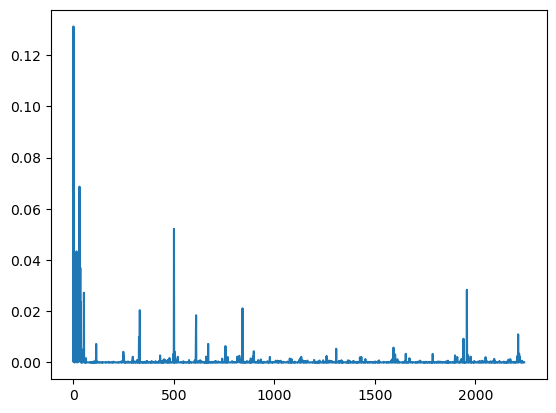

In [20]:
probs = np.exp(preds_v.predictions)
probs = probs / probs.sum(axis=1, keepdims=True)
np.sum(probs*np.arange(2244), axis = 1)
# np.exp(preds_v.predictions)
# probs.sum(axis=1)
plt.plot(probs[1])

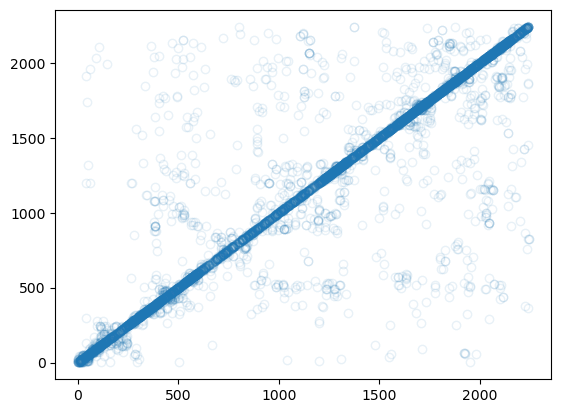

In [25]:
# plt.plot(np.sum(probs*np.arange(2244), axis = 1), preds_v.label_ids, 'o', fillstyle='none')
pred_v_ind = preds_v.predictions.argmax(axis=-1)
pred_t_ind = preds_t.predictions.argmax(axis=-1)
res_comp_v = (preds_v.predictions.argmax(axis=-1) == preds_v.label_ids)
res_comp_t = (preds_t.predictions.argmax(axis=-1) == preds_t.label_ids)
plt.plot(preds_v.predictions.argmax(axis=-1), preds_v.label_ids, 'o', fillstyle='none', alpha = .1)
# plt.plot(preds_t.predictions.argmax(axis=-1), preds_t.label_ids, 'o', fillstyle='none', alpha = .1)
# plt.plot(preds_r.predictions.argmax(axis=-1), preds_r.label_ids, 'o', fillstyle='none')
# plt.plot([22000, 34000], [22000, 34000], 'r-')
# plt.xlim([22000, 34000])
# plt.ylim([22000, 34000])

In [22]:
res_comp_v.sum()/len(res_comp_v), res_comp_t.sum()/len(res_comp_t)

(0.5435154707044108, 0.5667632341322096)

In [23]:
trainer.push_to_hub("amirkazemim/bert_base_cased_finetuned_products_2")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/amirkazemim/bert-base-cased-finetuned-products_2/commit/f0b77957ecc8527367a8db75c6982f0e57174bf1', commit_message='amirkazemim/bert_base_cased_finetuned_products_2', commit_description='', oid='f0b77957ecc8527367a8db75c6982f0e57174bf1', pr_url=None, pr_revision=None, pr_num=None)

In [24]:
unq_arr = id_chk.u
unq_arr.shape

(2244, 6)

In [29]:
pred_arr_t, lab_arr_t = unq_arr[pred_t_ind], unq_arr[preds_t.label_ids]
pred_arr_v, lab_arr_v = unq_arr[pred_v_ind], unq_arr[preds_v.label_ids]

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

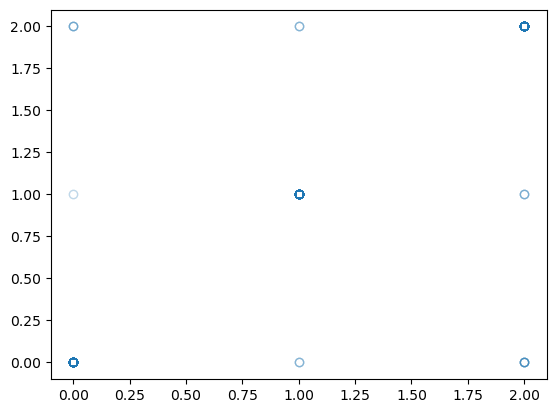

In [31]:
# plt.plot(pred_arr_t[:,0], lab_arr_t[:,0], 'o', fillstyle='none', alpha = .1)
plt.plot(pred_arr_v[:,0], lab_arr_v[:,0], 'o', fillstyle='none', alpha = .1)

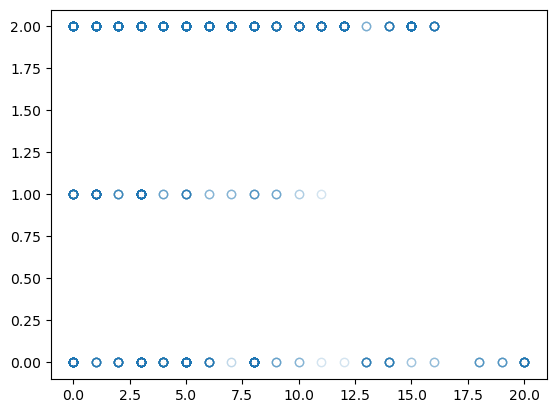

In [41]:
# plt.plot(lab_arr_v[:,1], lab_arr_v[:,0], 'o', fillstyle='none', alpha = .1)
plt.plot(lab_arr_v[:,2], lab_arr_v[:,0], 'o', fillstyle='none', alpha = .1)
# plt.plot(lab_arr_v[:,1], lab_arr_v[:,1]+9*lab_arr_v[:,0], 'o', fillstyle='none', alpha = .1)
# plt.plot(lab_arr_t[:,1], lab_arr_t[:,1]+9*lab_arr_t[:,0], 'o', fillstyle='none', alpha = .1, markersize = 10)

In [64]:
text_v = imdb_encoded['validation']['text']
text_t = imdb_encoded['test']['text']

In [80]:
pd.options.display.max_colwidth = 200

In [98]:
mix_inds = np.where((lab_arr_v[:,0] == 2) & (pred_arr_v[:,0] == 1))[0]
# mix_inds = np.where((lab_arr_v[:,0] == 2) & (pred_arr_v[:,0] == 0))[0]
# mix_inds = np.where((lab_arr_v[:,0] == 1) & (pred_arr_v[:,0] == 0))[0]
# mix_inds = np.where((lab_arr_v[:,0] == 1) & (pred_arr_v[:,0] == 2))[0]
# mix_inds = np.where((lab_arr_v[:,0] == 0) & (pred_arr_v[:,0] == 2))[0]
# mix_inds = np.where((lab_arr_v[:,0] == 0) & (pred_arr_v[:,0] == 1))[0]
for iv in mix_inds:
    print(iv, text_v[iv])
    # print('')

1328 RW Knudsen Family 100% Juice, Red Tart Cherry32 fl oz
2755 Inko's White Tea, Organic, White Peach64 fl oz
3479 Gngr Vitamin C Booster Organic Ginger & Turmeric Shot2 fl oz
3623 Old Orchard 100% Juice, Grape12 fl oz
3627 Old Orchard 100% Juice, Cranberry Blend12 fl oz
4989 Reese's Tapioca, Large Pearl7 oz
5094 Host Defense Drink Mix, Cocoa, MycoBrew0.5 oz


In [100]:
# df_copy.loc[df_copy['product'] == text_v[257], 'label']
for iv in mix_inds:
    print(iv, df_copy[df_copy['product'] == text_v[iv]]['link'].to_string())
    # print('')
# df_copy[df_copy['product'] == text_v[3628]]['link']

1328 17294    https://www.instacart.com/products/42823242-rwk-cha-cha-cherry-tart-32-oz
2755 35110    https://www.instacart.com/products/175857-inko-s-white-tea-organic-white-peach-64-oz
3479 42676    https://www.instacart.com/products/25930247-dora-s-natural-ginger-turmeric-16-oz
3623 45420    https://www.instacart.com/products/123004-old-orchard-100-juice-grape-frozen-concentrate-12-oz
3627 45435    https://www.instacart.com/products/201641-old-orchard-cranberry-blend-100-juice-frozen-concentrate-12-oz
4989 69528    https://www.instacart.com/products/76394-reese-s-tapioca-large-pearl-7-oz
5094 66743    https://www.instacart.com/products/26295920-host-defense-mycobrew-cocoa-superfood-mushroom-mycelium-drink-mix-15-g


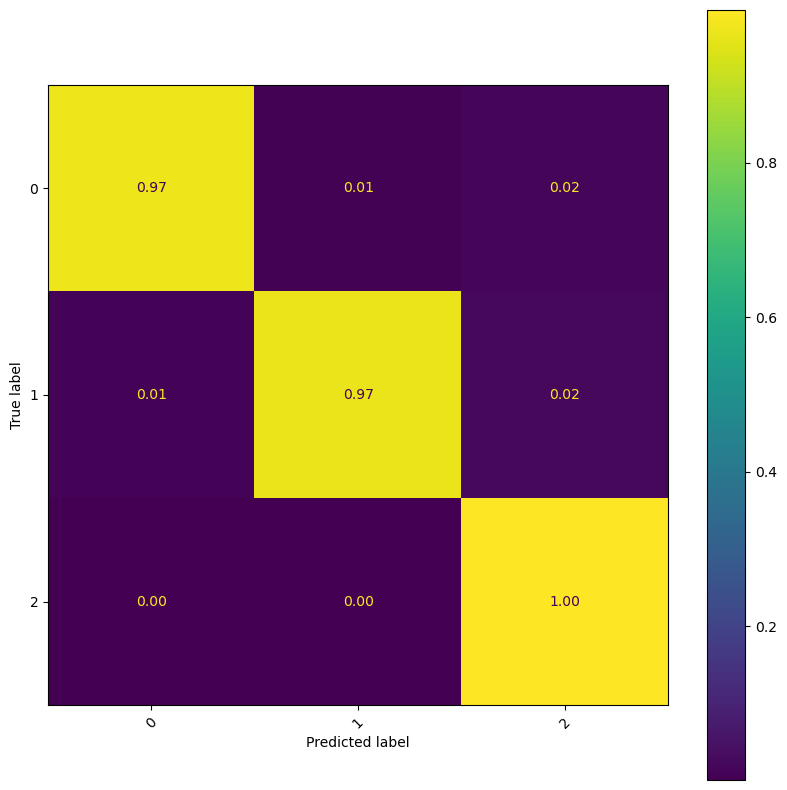

In [57]:
fig, ax = plt.subplots(figsize=(10, 10)) 
# fig, ax = plt.subplots(figsize=(40, 40)) 

# cm = confusion_matrix(y_true=lab_arr_v[:,2]+20*9*lab_arr_v[:,0]+20*lab_arr_v[:,1], y_pred=pred_arr_v[:,2]+20*9*pred_arr_v[:,0]+20*pred_arr_v[:,1], normalize='true')
# cm = confusion_matrix(y_true=lab_arr_v[:,1]+9*lab_arr_v[:,0], y_pred=pred_arr_v[:,1]+9*pred_arr_v[:,0], normalize='true')
cm = confusion_matrix(y_true=lab_arr_v[:,0], y_pred=pred_arr_v[:,0], normalize='true')
# cm = confusion_matrix(y_true=lab_arr_v[:,1], y_pred=pred_arr_v[:,1], normalize='true')
# cm = confusion_matrix(y_true=lab_arr_v[:,2], y_pred=pred_arr_v[:,2], normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(ax=ax, cmap='viridis', xticks_rotation=45, values_format='.2f') 
# fig.patch.set_alpha(1)
# fig.savefig('confusion_matrix.pdf', dpi=300, bbox_inches='tight', format='pdf')

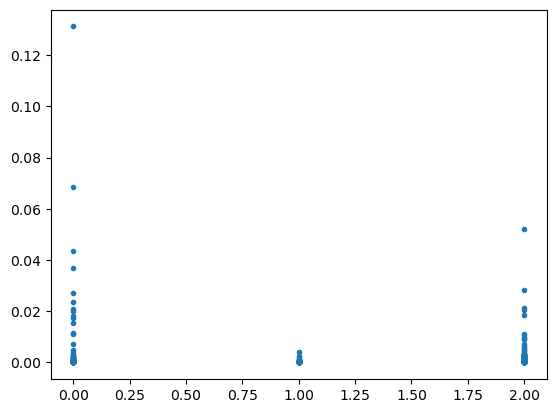

In [51]:
probs_v = np.exp(preds_v.predictions)
probs_t = np.exp(preds_t.predictions)
probs_v = probs_v / probs_v.sum(axis=1, keepdims=True)
probs_t = probs_t / probs_t.sum(axis=1, keepdims=True)
# np.sum(probs*np.arange(2244), axis = 1)
# np.exp(preds_v.predictions)
# probs.sum(axis=1)
# plt.plot(probs_v[1], '-o')
plt.plot(unq_arr[:,0], probs_v[1], '.')

In [100]:
ii=67
iu, uc = unq_ids[ii], unq_cnt[ii]
pred_sel = pred_labs[np.where(preds.label_ids == iu)[0]]
prc_u = np.sum(pred_sel == iu)
print(pred_sel)
if uc>10:
    print(f'{iu}: {uc}, {prc_u}, {prc_u/uc:.2f}')

[9469 9469 9943 9469 9737 9469 9469 9932 9929 9943 9943 9470 9666 9932
 9943 9932 9469 9932 9943 9943 9469 9929 9943 9943 9943 9469 9469 9469
 9469 9933 9943 9943 9943 9943 9943 9943 9943 9929 9469 9943 9943 9929
 9943 9943 9929 9943 9469 9469 9469 9929 9469 9469 9469 9943 9929 9929
 9469 9469 9943 9943 9737 9469 9943 9470 9470 9535 9667 9932 9943 9666
 9943 9667 9943 9469 9929 9929 9943 9943 9943 9996 9932 9535]
9469: 82, 22, 0.27


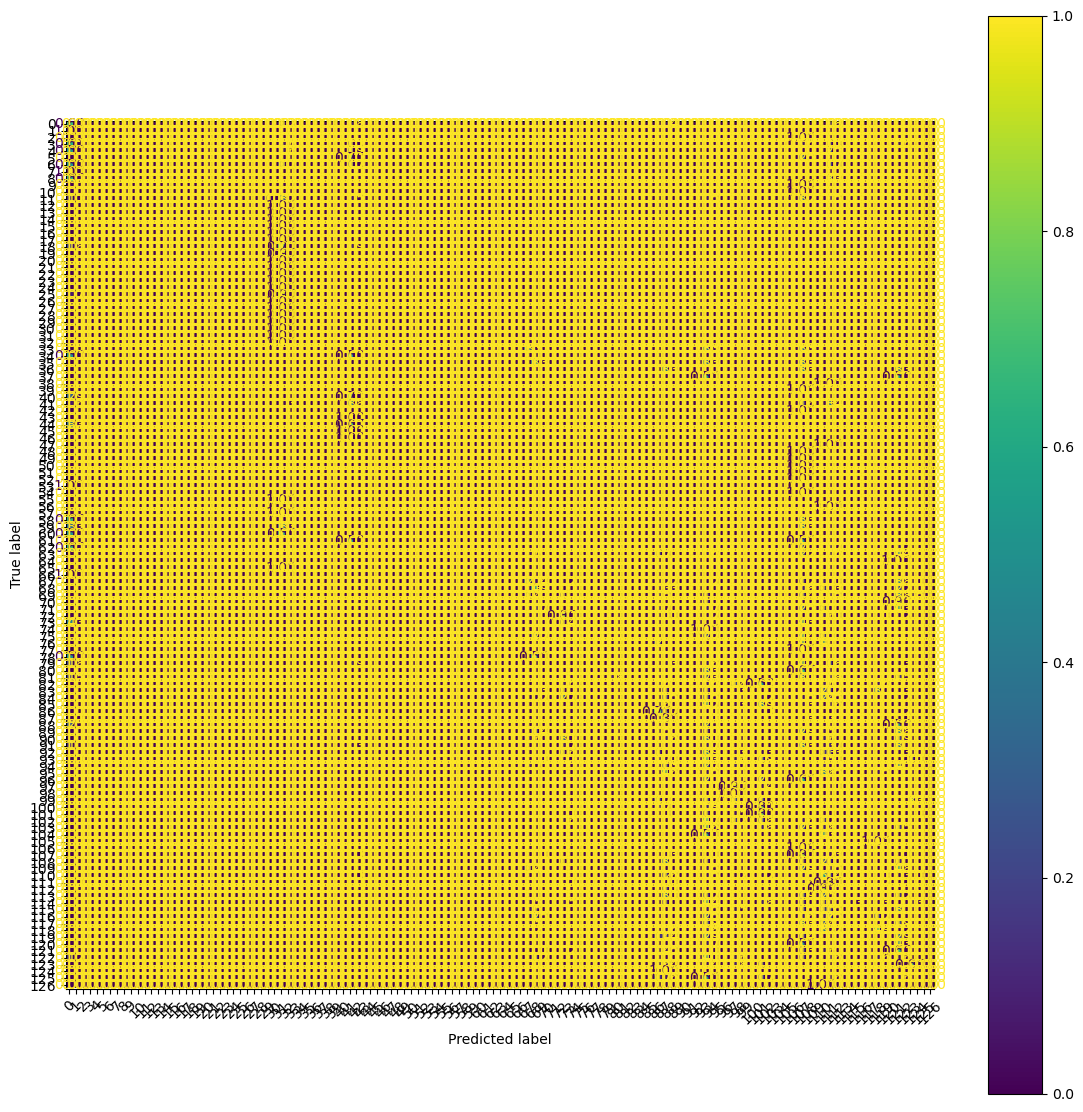

In [79]:
fig, ax = plt.subplots(figsize=(14, 14)) 

cm = confusion_matrix(y_true=preds.label_ids, y_pred=preds.predictions.argmax(axis=-1), normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(ax=ax, cmap='viridis', xticks_rotation=45, values_format='.2f') 


In [352]:
for ids in range(len(imdb_encoded['test'])):
    print(imdb_encoded['test'][ids]['label'], classifier(imdb_encoded['test'][ids]['text'])[0]['label'])

65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_268
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_65
65 LABEL_68
65 LABEL_68
65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_65
66 LABEL_65
66 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_215
65 LABEL_68
65 LABEL_215
65 LABEL_68
65 LABEL_65
65 LABEL_268
65 LABEL_268
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_65
65 LABEL_270
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_65
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_65
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_65
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_65
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_68
71 LABEL_65
71 LABEL_65
71 LABEL_65
71 LABEL_65
71 LABEL_65
71 LABEL_68
67 LABEL_68
69 LABEL_68
69 LABEL_68
69 LABEL_69
69 LABEL_65
69 LABEL_65
69 LABEL_65
69 LABEL_65
69 LABEL_69
69 LABEL_65
69 LABEL_68
69 LABEL_65
69 LABEL_268
69 LABEL_

KeyboardInterrupt: 